In [74]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

In [75]:
data = loadmat("dados_sistema.mat")
x = data["x"]
d = data["d"]

In [76]:
def autocorrelation_matrix(X, M):
    """
    Calculates the autocorrelation matrix with M lags for a given array X.

    Parameters:
    X (np.array): Input 1D array of data points.
    M (int): Number of lags to use for the autocorrelation matrix.

    Returns:
    np.array: The autocorrelation matrix of shape (M+1, M+1).
    """
    # Flatten the input array in case it's multidimensional
    X = X.flatten()
    
    # Create lagged versions of the array
    lagged_data = np.column_stack([np.roll(X, -lag)[:len(X) - M] for lag in range(M + 1)])
    
    # Compute the autocorrelation matrix
    autocorr_matrix = np.corrcoef(lagged_data, rowvar=False)
    
    return autocorr_matrix

def cross_correlation_vector(X, Y, M):
    """
    Calculates the cross-correlation vector for M lags between two vectors X and Y.

    Parameters:
    X (np.array): First input 1D array of data points.
    Y (np.array): Second input 1D array of data points, should be the same length as X.
    M (int): Number of lags to calculate for the cross-correlation.

    Returns:
    np.array: A 1D array containing the cross-correlation values for each lag up to M.
    """
    # Ensure X and Y are 1D arrays and have the same length
    X = X.flatten()
    Y = Y.flatten()
    assert len(X) == len(Y), "X and Y must be of the same length"
    
    # Mean-center the data for unbiased cross-correlation
    X = X - X.mean()
    Y = Y - Y.mean()
    
    # Calculate cross-correlation for each lag up to M
    cross_corr = np.array([
        np.sum(X[:len(X) - lag] * Y[lag:]) / (len(X) - lag)
        for lag in range(M + 1)
    ])
    
    return cross_corr

def calculate_w_opt(x, d, M):
    R = autocorrelation_matrix(x, M)
    R_inv = np.linalg.inv(R)
    p = cross_correlation_vector(x, d, M)
    return R_inv @ p

def apply_fir_filter(w, x):
    x = x.flatten()
    # Ensure the input is a NumPy array
    x = np.asarray(x)
    w = np.asarray(w)
    
    # Get the order of the filter
    M = len(w)
    # Initialize the output signal with zeros
    output_signal = np.zeros(len(x))

    # Apply the FIR filter using convolution
    for n in range(len(x)):
        for k in range(M):
            if n - k >= 0:  # Check bounds to avoid negative indices
                output_signal[n] += w[k] * x[n - k]

    return output_signal  

In [77]:
w_opt_for_M = {}
for M in range(2,21,2):
    w_opt_for_M[str(M)] = calculate_w_opt(x, d, M)

In [78]:
w_opt_for_M

{'2': array([1.01383218, 0.40120124, 0.36511441]),
 '4': array([ 1.01454041,  0.40344225,  0.3637605 , -0.07816108,  0.27983665]),
 '6': array([ 1.01345365,  0.40601525,  0.36571803, -0.07800031,  0.27516239,
         0.12594287,  0.2580014 ]),
 '8': array([ 1.01177945,  0.40698764,  0.36484119, -0.07715957,  0.27574439,
         0.12633484,  0.25638101,  0.01758816,  0.11816668]),
 '10': array([ 1.01424084,  0.40629428,  0.36336911, -0.07611986,  0.27476555,
         0.12675147,  0.25692853,  0.01793401,  0.11635806,  0.01756826,
         0.11597748]),
 '12': array([ 1.01534954,  0.40655767,  0.36533469, -0.07630353,  0.27421283,
         0.12736538,  0.25609653,  0.01759411,  0.11652207,  0.0176082 ,
         0.11430961,  0.02077123,  0.06768289]),
 '14': array([ 1.01529477,  0.40691418,  0.36651   , -0.07600349,  0.27562832,
         0.12743377,  0.25553131,  0.01817667,  0.11586434,  0.01730686,
         0.11427076,  0.02096598,  0.06671499,  0.00249601,  0.04912413]),
 '16': array

D [ 0.30015252 -0.21378925 -1.79840561 ...  0.44594243 -0.86467023
 -0.7501559 ]
len D 10000
y [ 0.30430429 -0.21804658 -1.8217949  ... -0.64293532 -1.19802014
 -1.34335057]
len y 10000
error [1.72371455e-05 1.81247924e-05 5.47058807e-04 ... 1.18565476e+00
 1.11122163e-01 3.51879918e-01]

D [ 0.30015252 -0.21378925 -1.79840561 ...  0.44594243 -0.86467023
 -0.7501559 ]
len D 10000
y [ 0.30451687 -0.21761038 -1.82420508 ... -0.34933592 -1.1973937
 -1.50140391]
len y 10000
error [1.90474833e-05 1.46009658e-05 6.65612771e-04 ... 6.32467660e-01
 1.10704906e-01 5.64373583e-01]

D [ 0.30015252 -0.21378925 -1.79840561 ...  0.44594243 -0.86467023
 -0.7501559 ]
len D 10000
y [ 0.30419067 -0.21647527 -1.82254978 ...  0.11441002 -1.10413959
 -1.28735593]
len y 10000
error [1.63066413e-05 7.21466886e-06 5.82940929e-04 ... 1.09913741e-01
 5.73455717e-02 2.88583878e-01]

D [ 0.30015252 -0.21378925 -1.79840561 ...  0.44594243 -0.86467023
 -0.7501559 ]
len D 10000
y [ 0.30368815 -0.21562447 -1.82016936

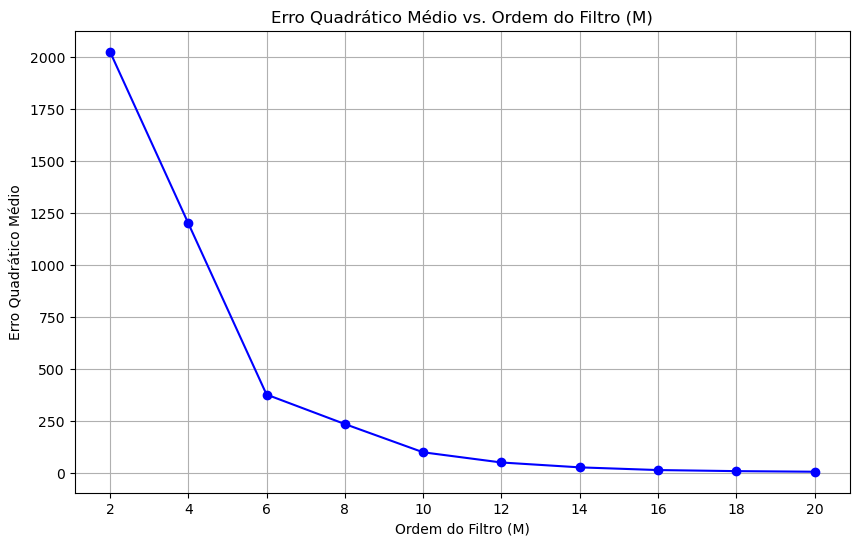

In [79]:
y_for_M = {}
e_for_M = {}

for M, w in w_opt_for_M.items():
    y_for_M[str(M)] = apply_fir_filter(w, x)
    e_for_M[str(M)] = np.sum((d.flatten() - y_for_M[str(M)])**2)/len(d)
    print("D", d.flatten())
    print("len D", len(d.flatten()))
    print("y", y_for_M[str(M)])
    print("len y", len(y_for_M[str(M)]))
    print("error", (d.flatten() - y_for_M[str(M)])**2)
    print()

# Extracting keys and values
M_values = list(e_for_M.keys())
squared_errors = list(e_for_M.values())

# Plotting the curve
plt.figure(figsize=(10, 6))
plt.plot(M_values, squared_errors, marker='o', linestyle='-', color='b')
plt.title('Erro Quadrático Médio vs. Ordem do Filtro (M)')
plt.xlabel('Ordem do Filtro (M)')
plt.ylabel('Erro Quadrático Médio')
plt.grid()
plt.xticks(M_values)  # Show all M values on the x-axis
# plt.yscale('log')  # Optional: use logarithmic scale for better visibility
plt.show()


In [80]:
e_for_M

{'2': 2025.0539434455882,
 '4': 1200.4355461990742,
 '6': 377.00718248928473,
 '8': 235.29517506216746,
 '10': 99.5011004213782,
 '12': 50.484676355394996,
 '14': 27.070740179472818,
 '16': 14.123263262710859,
 '18': 8.939599117133518,
 '20': 6.095345188577243}

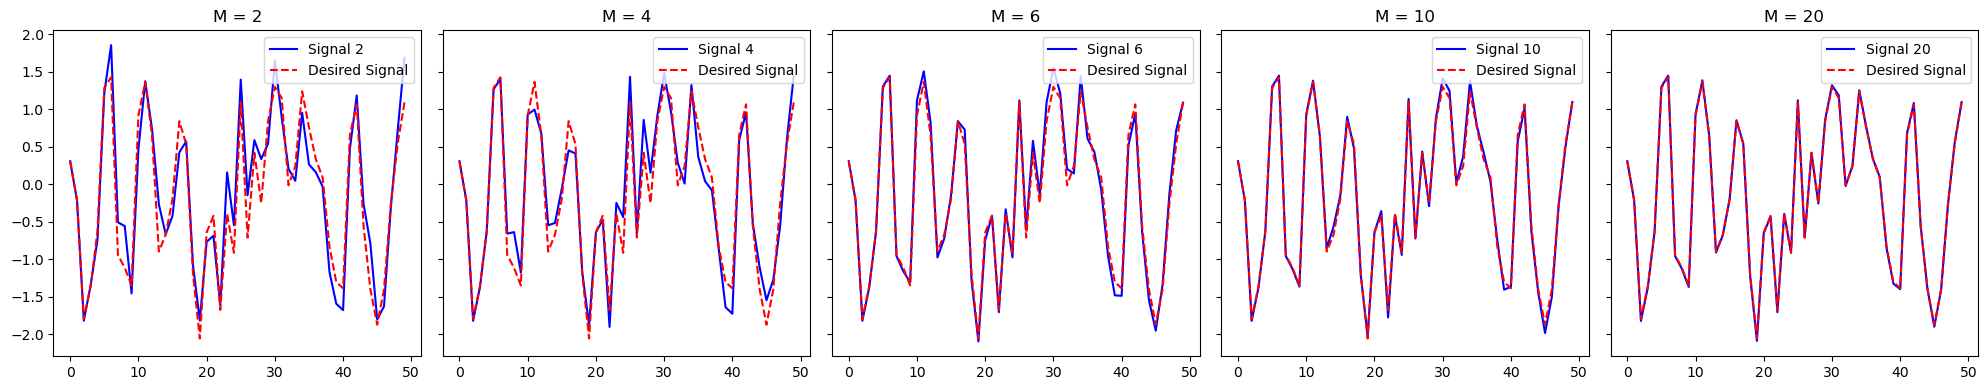

In [84]:
import matplotlib.pyplot as plt

# Define o número de subplots (5 no total) e cria uma figura e eixos
fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)  # 1 linha, 5 colunas
y_for_M_ = {k:val for k, val in y_for_M.items() if k in ["2", "4", "6", "10", "20"]}
# Itera sobre os valores de y_for_M e o índice do subplot
for i, (M, y) in enumerate(y_for_M_.items()):
    axs[i].set_title(f"M = {M}")
    axs[i].plot(range(50), y[:50], label=f"Sinal Estimado", color="b")
    axs[i].plot(range(50), d.flatten()[:50], label="Sinal Real", color="r", linestyle="--")
    axs[i].legend()  # Adiciona a legenda para cada subplot

# Exibe todos os subplots em uma única figura
plt.tight_layout()
plt.show()


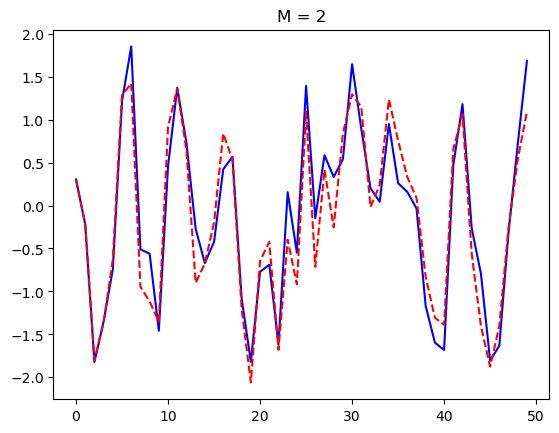

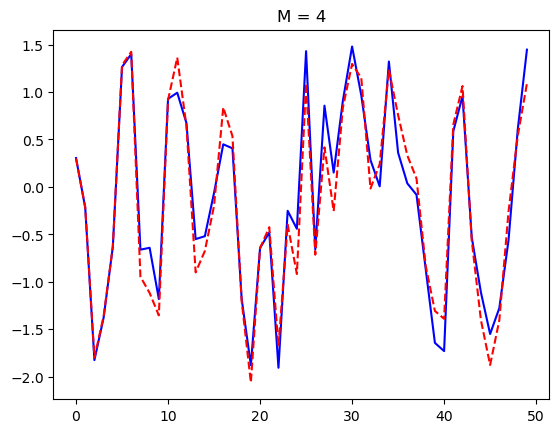

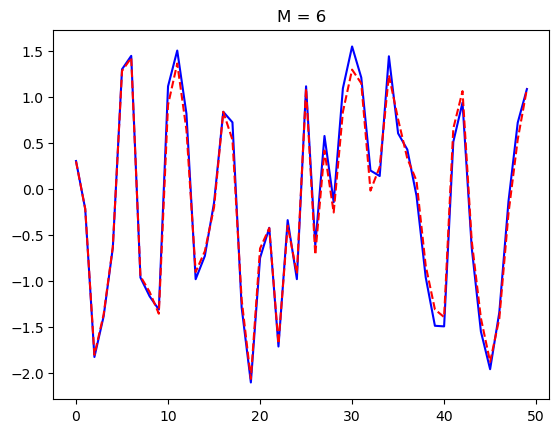

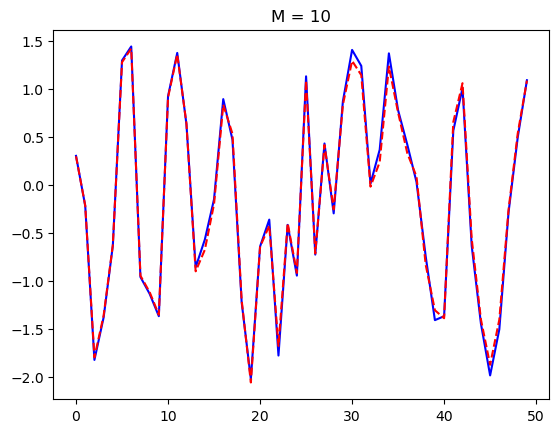

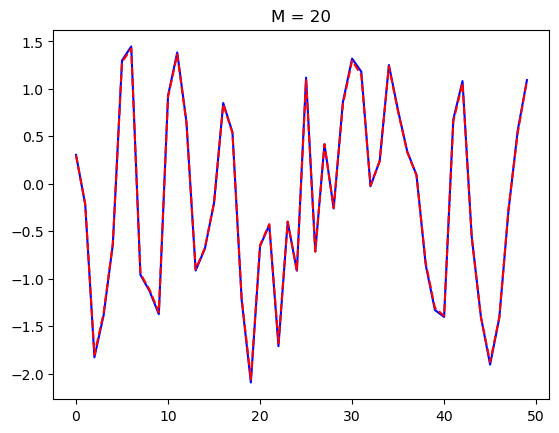

In [82]:
for M, y in y_for_M.items():
    if M in ["2", "4", "6", "10", "20"]:
        plt.title(f"M = {M}")
        plt.plot(range(50), y[:50], label=f"Signal {M}", color="b")
        plt.plot(range(50), d.flatten()[:50], label=f"Desired Signal", color="r", linestyle="--")
        plt.show()

### Parte FEPPU

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def calcular_fep_otimo(sinal, num_coeficientes):
    """
    Calcula os coeficientes do Filtro de Estimação de Parâmetros (FEP) ótimo.
    
    :param sinal: O sinal de entrada (numpy array).
    :param num_coeficientes: O número de coeficientes desejados para o filtro.
    :return: Os coeficientes do FEP.
    """
    sinal = np.asarray(sinal)
    R = np.correlate(sinal, sinal, mode='full')
    R = R[len(R)//2:]  # Parte positiva da autocovariância
    
    # Monta a matriz R e o vetor r
    R_matrix = np.zeros((num_coeficientes, num_coeficientes))
    for i in range(num_coeficientes):
        for j in range(num_coeficientes):
            R_matrix[i, j] = R[abs(i - j)]
    
    r = np.zeros(num_coeficientes)
    for i in range(num_coeficientes):
        r[i] = R[i + 1]  # R[0] é a variância do sinal
    
    # Calcula os coeficientes ótimos
    coeficientes = np.linalg.solve(R_matrix, r)
    return coeficientes

def aplicar_fep(sinal, coeficientes):
    """
    Aplica o Filtro de Estimação de Parâmetros (FEP) ao sinal usando coeficientes ótimos.
    
    :param sinal: O sinal de entrada (numpy array).
    :param coeficientes: Coeficientes do filtro (numpy array).
    :return: Sinal filtrado e erro de predição.
    """
    num_coeficientes = len(coeficientes)
    preditor = np.zeros(len(sinal))
    erro = np.zeros(len(sinal))
    
    # Aplicando o filtro
    for n in range(num_coeficientes, len(sinal)):
        # Certifique-se de pegar exatamente num_coeficientes amostras anteriores
        preditor[n] = np.dot(coeficientes, sinal[n-num_coeficientes:n][::-1])
        erro[n] = sinal[n] - preditor[n]
    
    return preditor, erro

# Parâmetros
num_coeficientes = 5
error_for_k = {}

for k in range(1, 20):
    sinal = d.flatten()
    coeficientes = calcular_fep_otimo(sinal, k)
    preditor, erro = aplicar_fep(sinal, coeficientes)
    error_for_k[str(k)] = np.mean(erro ** 2)


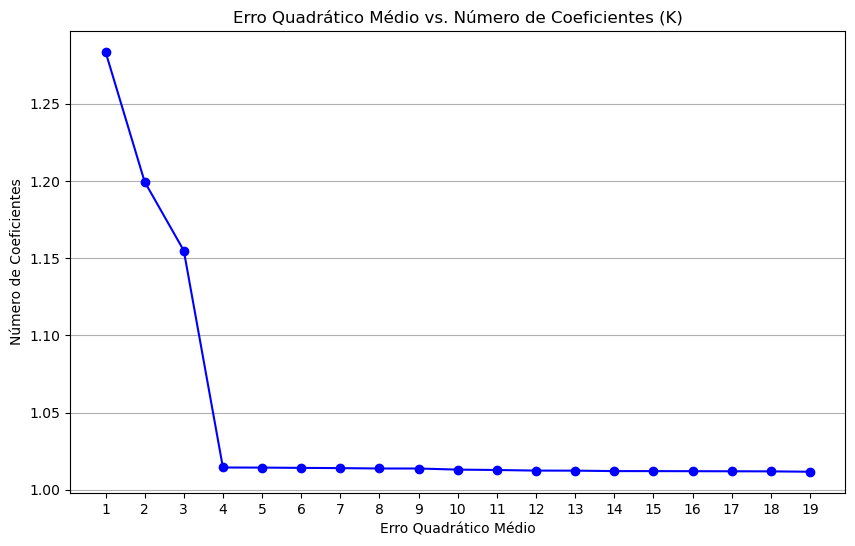

In [73]:
# Extraindo chaves e valores
chaves = list(error_for_k.keys())
valores = list(error_for_k.values())

# Criando o gráfico
plt.figure(figsize=(10, 6))
plt.plot(chaves, valores, marker='o', linestyle='-', color='b')
plt.xlabel('Erro Quadrático Médio')
plt.ylabel('Número de Coeficientes')
plt.title('Erro Quadrático Médio vs. Número de Coeficientes (K)')
plt.grid(axis='y')

# Exibindo o gráfico
plt.show()